# Background

This notebook serves as the preliminary analysis and proof-of-work of the implementation in the other Python files of this project.

In [1]:
%matplotlib inline

/home/angelo/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
import numpy as np
import networkx as nx
import stim
import sinter
import model

import matplotlib.pyplot as plt

In [3]:
# Edit matplotlib parameters
plt.rcParams.update(
    {
        "text.usetex": True,  # WARNING: make false if no TeX compiler installed
        "font.family": "Serif",
        "figure.dpi": 300,
    }
)

## Surface Code and Decoding

We start with generating a surface code from our standalone implementation.

In [ ]:
surface_code = model.StabilizerModel("surface_code:x_memory", scale=(3,3), rounds=2)

In [ ]:
surface_code.circuit.without_noise().diagram("timeline")

In [ ]:
surface_code_tasks = [
    sinter.Task(
        circuit=model.StabilizerModel(
            "surface_code:z_memory",
            scale=(distance, distance),
            rounds=distance * 3,
            noise_circuit=0.0,
            noise_data=noise,
            noise_x_check=noise,
            noise_z_check=noise,
        ).circuit,
        json_metadata={"distance": distance, "round": distance * 3, "noise": noise},
    )
    for distance in [5, 7, 9]
    for noise in np.linspace(0.001, 0.10, 40)
]

In [ ]:
collected_surface_code_stats = sinter.collect(
    num_workers=4,
    tasks=surface_code_tasks,
    decoders=["pymatching"],
    max_shots=1_000_000,
    max_errors=5_000,
    print_progress=True,
)

In [ ]:
fig = plt.figure(figsize=(8, 5))
sinter.plot_error_rate(
    ax=fig.gca(),
    stats=collected_surface_code_stats,
    x_func=lambda stat: stat.json_metadata['noise'],
    group_func=lambda stat: stat.json_metadata['distance'],
)
plt.ylim(1e-3, 1)
plt.xlim(1e-2, 0.1)
plt.loglog()
plt.title("Surface Code Error Rates per Round under Circuit Noise")
plt.xlabel("Phyical Error Rate")
plt.ylabel("Logical Error Rate per Round")
plt.grid(which='major')
plt.grid(which='minor')

## Hypergraph Product Codes


### Implementation Introduction

We start with the HP code between the 3-repetition and $\text{Hamming}[7,4]$ codes. A classical code is represented as a `clist`, comprised of the order of bits `"B"` and checks `"C"`. Following the latter is a sequence of integers indicating the bit indices in the code which are to be included in the parity check.

The position of the qubits is given via the `pos` argument. This is a list of coordinates $(x_i,y_i)$ ordered relative to the standard rectangular embedding of the HP code such that $i=0$ corresponds to the top-left qubit, and for increasing $i$ we index qubits left to right, top to bottom.

In [4]:
clist_hamming_7_4 = ["B", "C", 0, 1, 5, 6, "B", "B", "C", 1, 2, 4, 5, "B", "B", "B", "C", 3, 4, 5, 6, "B"]
clist_rep_3 = ["B", "C", 0, 1, "B", "C", 1, 2, "B"]
pos_rep_3_rep_3 = [(x, 5 - y - 1) for y in range(5) for x in range(5)]
pos_rep_3_hamming_7_4 = [(x, 5 - y - 1) for y in range(5) for x in range(10)]

In [5]:
hp_code_rep_3_rep_3 = model.StabilizerModel(
    "hypergraph_product_code:z_memory",
    clist1=clist_rep_3,
    clist2=clist_rep_3,
    pos=pos_rep_3_rep_3,
    rounds=2,
)

hp_code_rep_3_hamming_7_4 = model.StabilizerModel(
    "hypergraph_product_code:x_memory",
    clist1=clist_rep_3,
    clist2=clist_hamming_7_4,
    pos=pos_rep_3_hamming_7_4,
    rounds=2,
)

The adjacency matrix specifying the graph is defined in the following block order:

$$A = \begin{pmatrix}
    0_{n} & H_Z^T & H_X^T\\
    H_Z & 0_{r_Z} & 0_{r_Z\times r_X}\\
    H_X & 0_{r_X\times r_Z} & 0_{r_X}
\end{pmatrix}$$

where the first block row in this matrix corresponds to data qubits, the second to $Z$ stabilizers and the last to $X$ stabilizers.

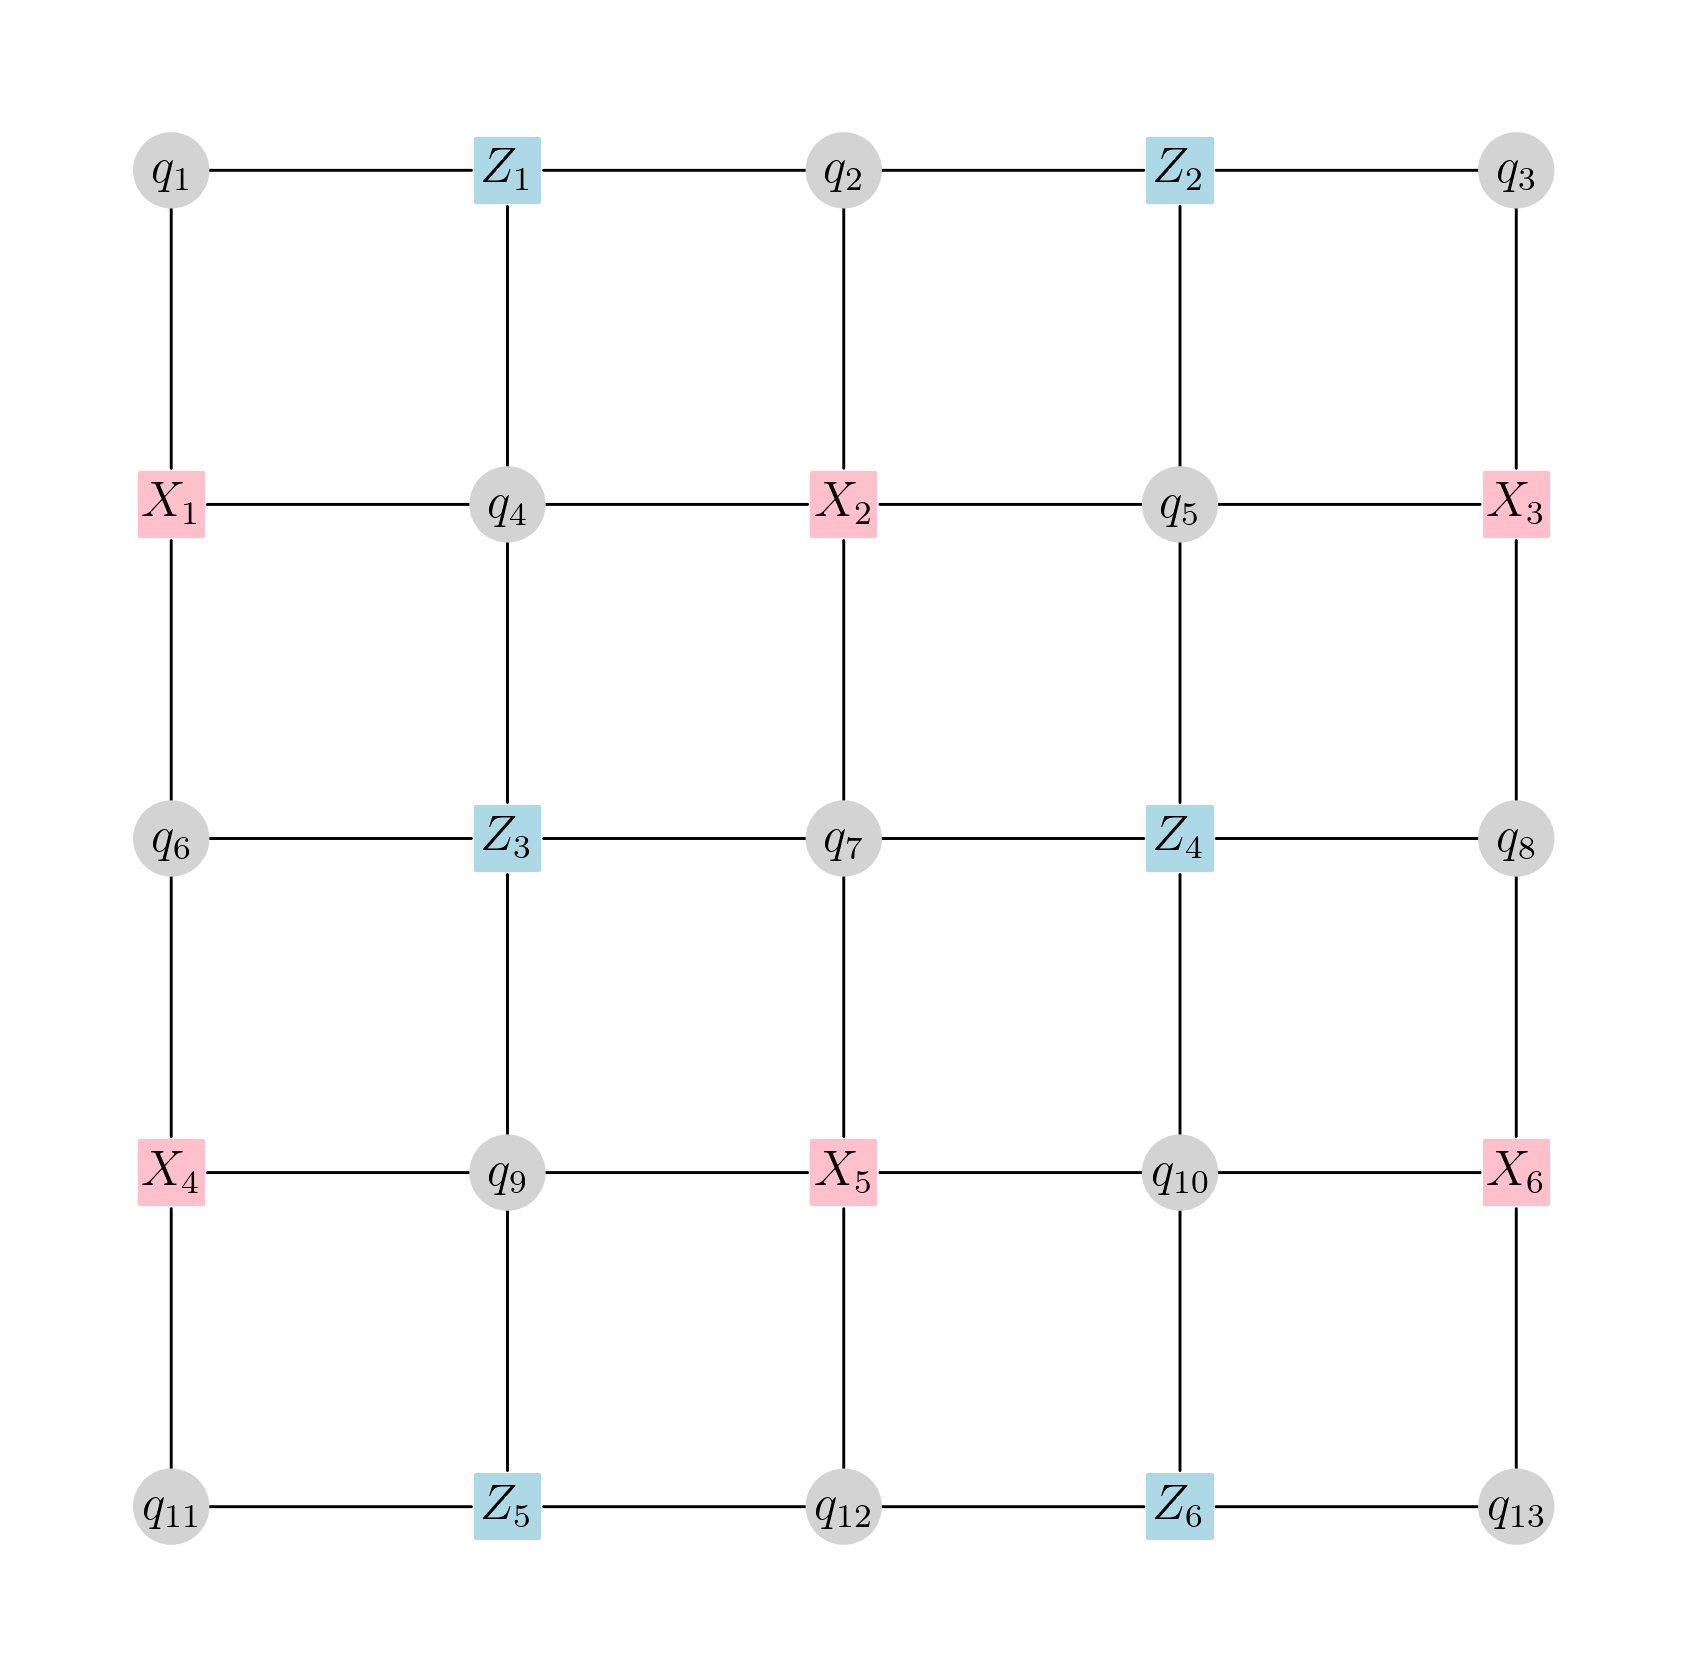

In [6]:
plt.figure(figsize=(7, 7))
hp_code_rep_3_rep_3.draw(with_labels=True)

### Crossings

Setting `connection_rad` to anything but zero (meaning straight edges) does not allow from crossings to be shown correctly. Internally, edges are always assumed to be straight, so this below is solely for illustration purposes.

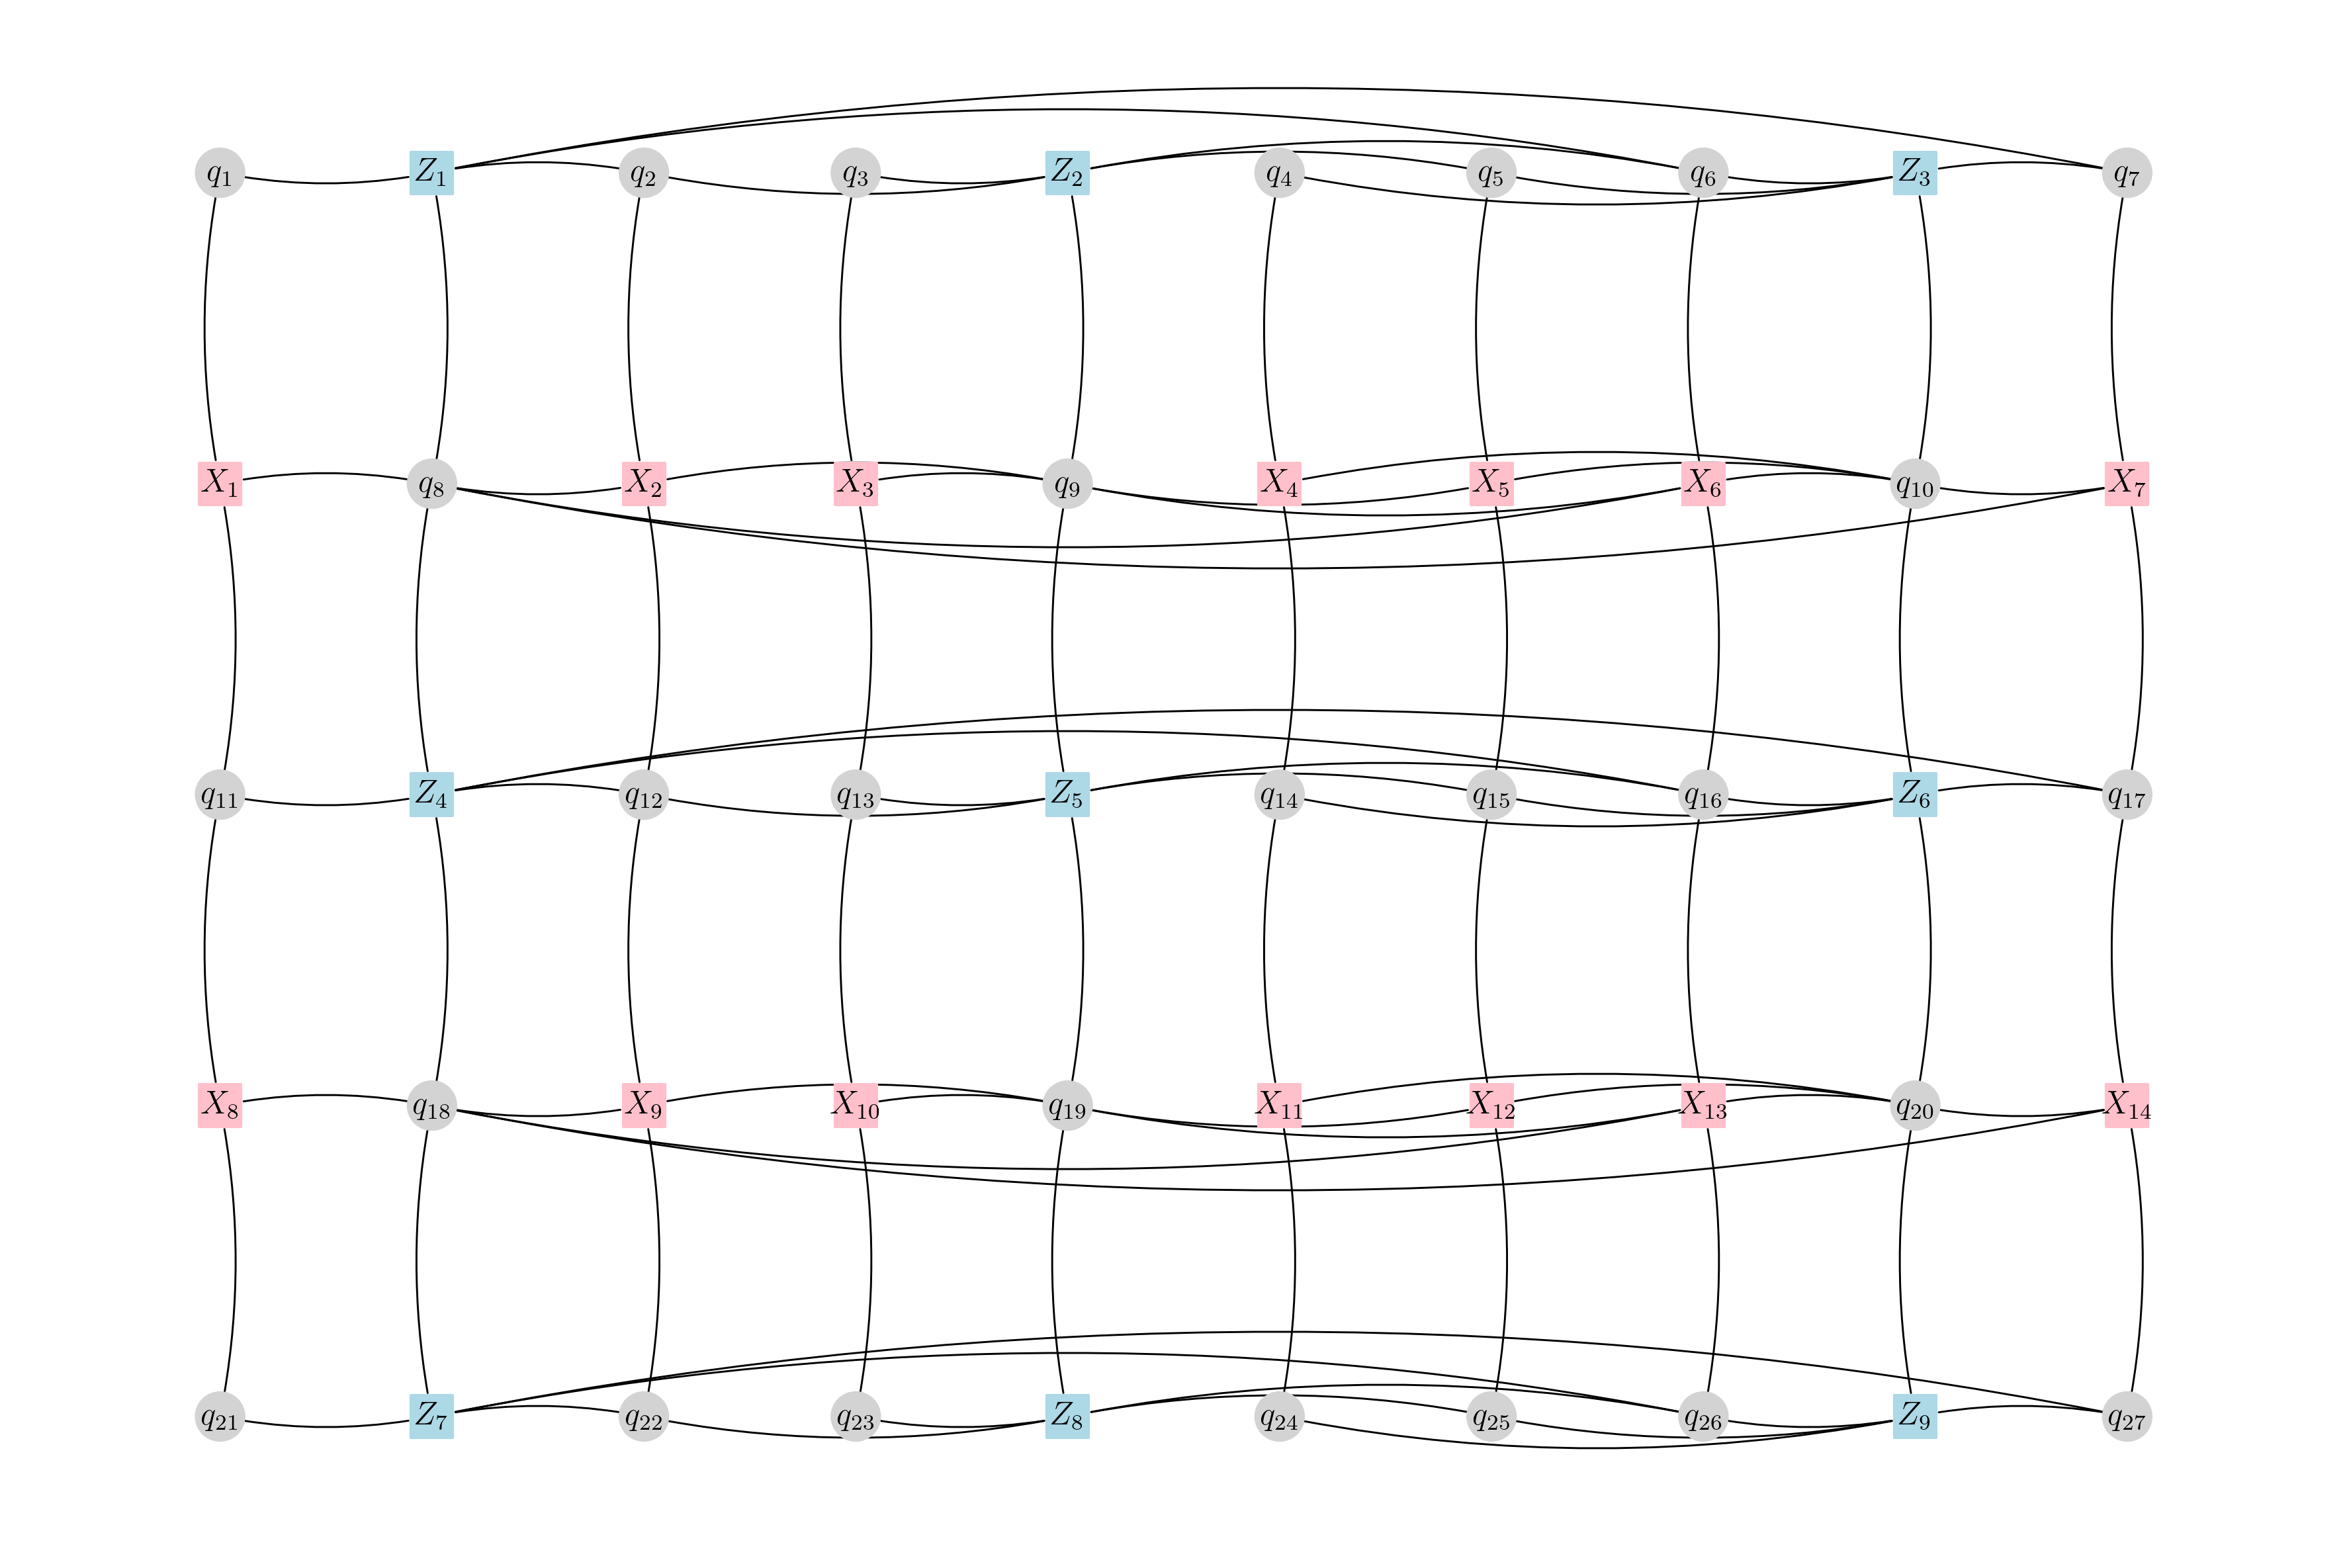

In [7]:
plt.figure(figsize=(15, 10))
hp_code_rep_3_hamming_7_4.draw(with_labels=True, crossings=False, connection_rad=0.1)

To have the intended edges, like those above, be implemented correctly in the error application algorithm, we are not allowed to have three or more collinear nodes with edges passing through them. Hence, we may nudge the qubits in order to apply the crossings as intended.

In [8]:
pos_rep_3_hamming_7_4_adjusted = []
for y in range(5):
    for x in range(10):
        curr_coords = [x, 5 - y - 1]
        if x == 1:
            curr_coords[1] += 1
        elif x == 4:
            curr_coords[1] += 0.3
        elif x == 8:
            curr_coords[1] -= 0.5 
        pos_rep_3_hamming_7_4_adjusted.append(tuple(curr_coords))
        
hp_code_rep_3_hamming_7_4_adjusted = model.StabilizerModel(
    "hypergraph_product_code:x_memory",
    clist1=clist_rep_3,
    clist2=clist_hamming_7_4,
    pos=pos_rep_3_hamming_7_4_adjusted,
    rounds=2,
)

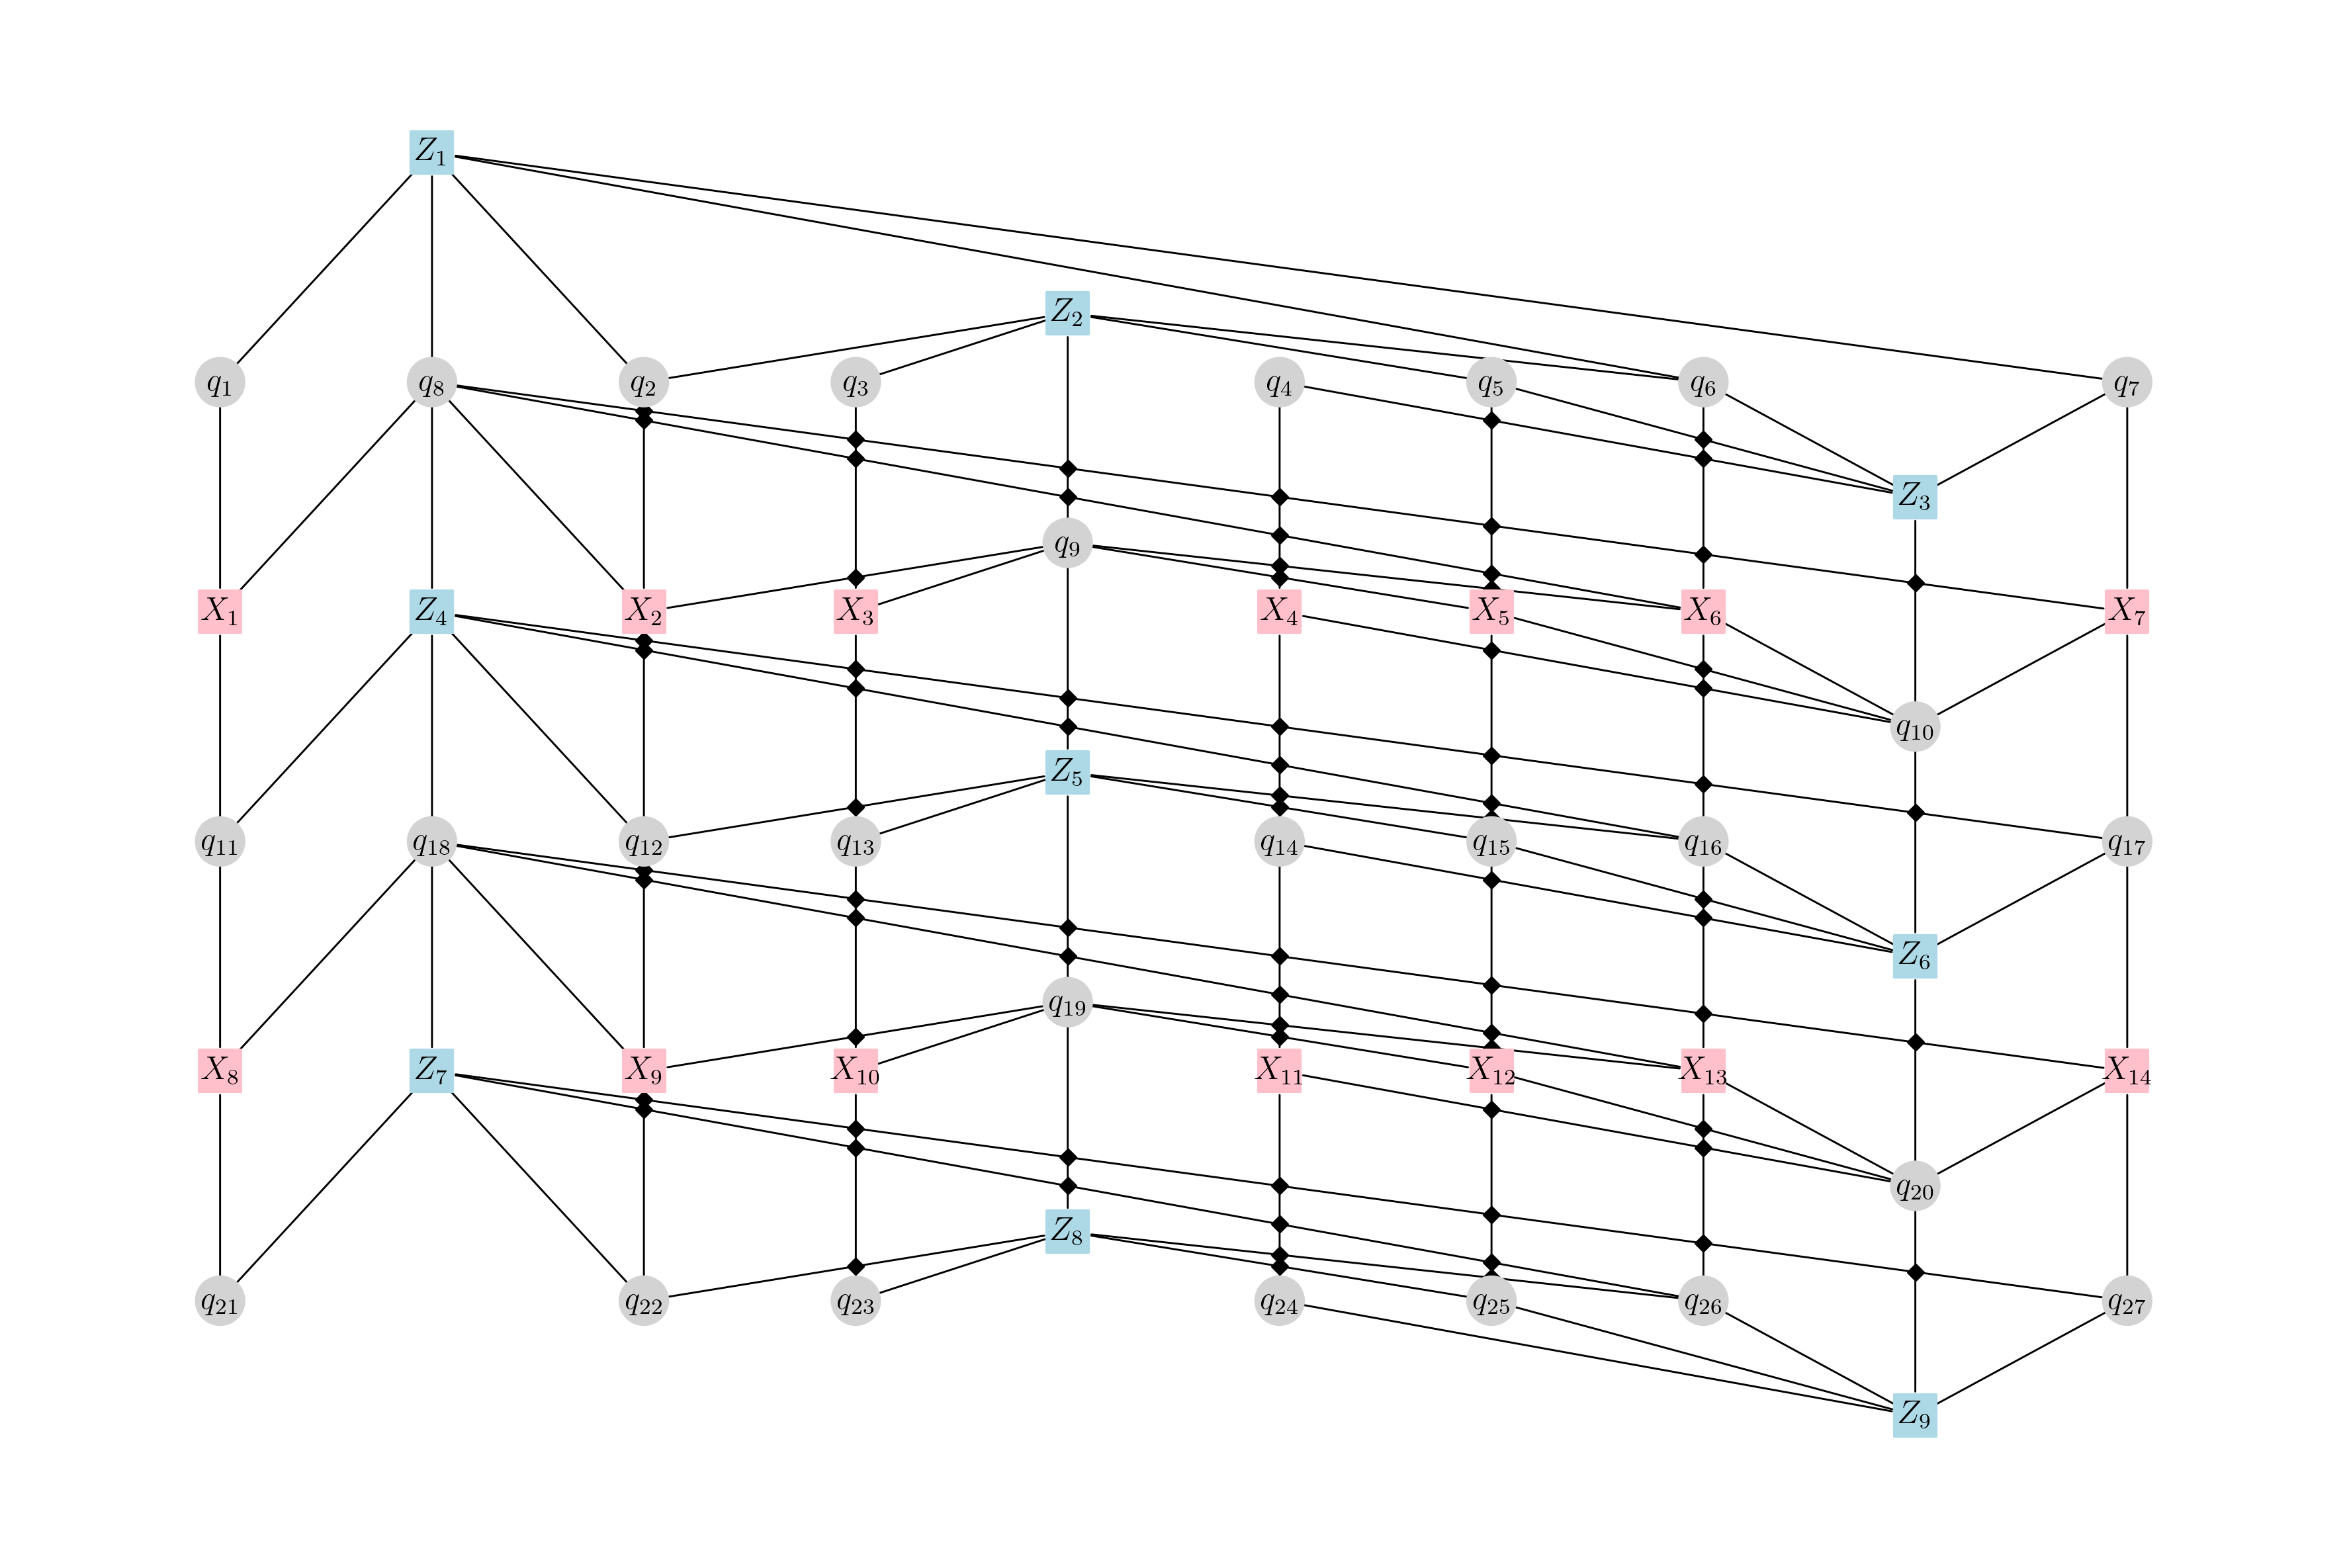

In [9]:
plt.figure(figsize=(15, 10))
hp_code_rep_3_hamming_7_4_adjusted.draw(with_labels=True)

We could instead try a variety of different predefined positioning algorithms.

In [14]:
hp_code_rep_3_hamming_7_4_spring = model.StabilizerModel(
    "hypergraph_product_code:x_memory",
    clist1=clist_rep_3,
    clist2=clist_hamming_7_4,
    pos="spring",
    rounds=2,
)

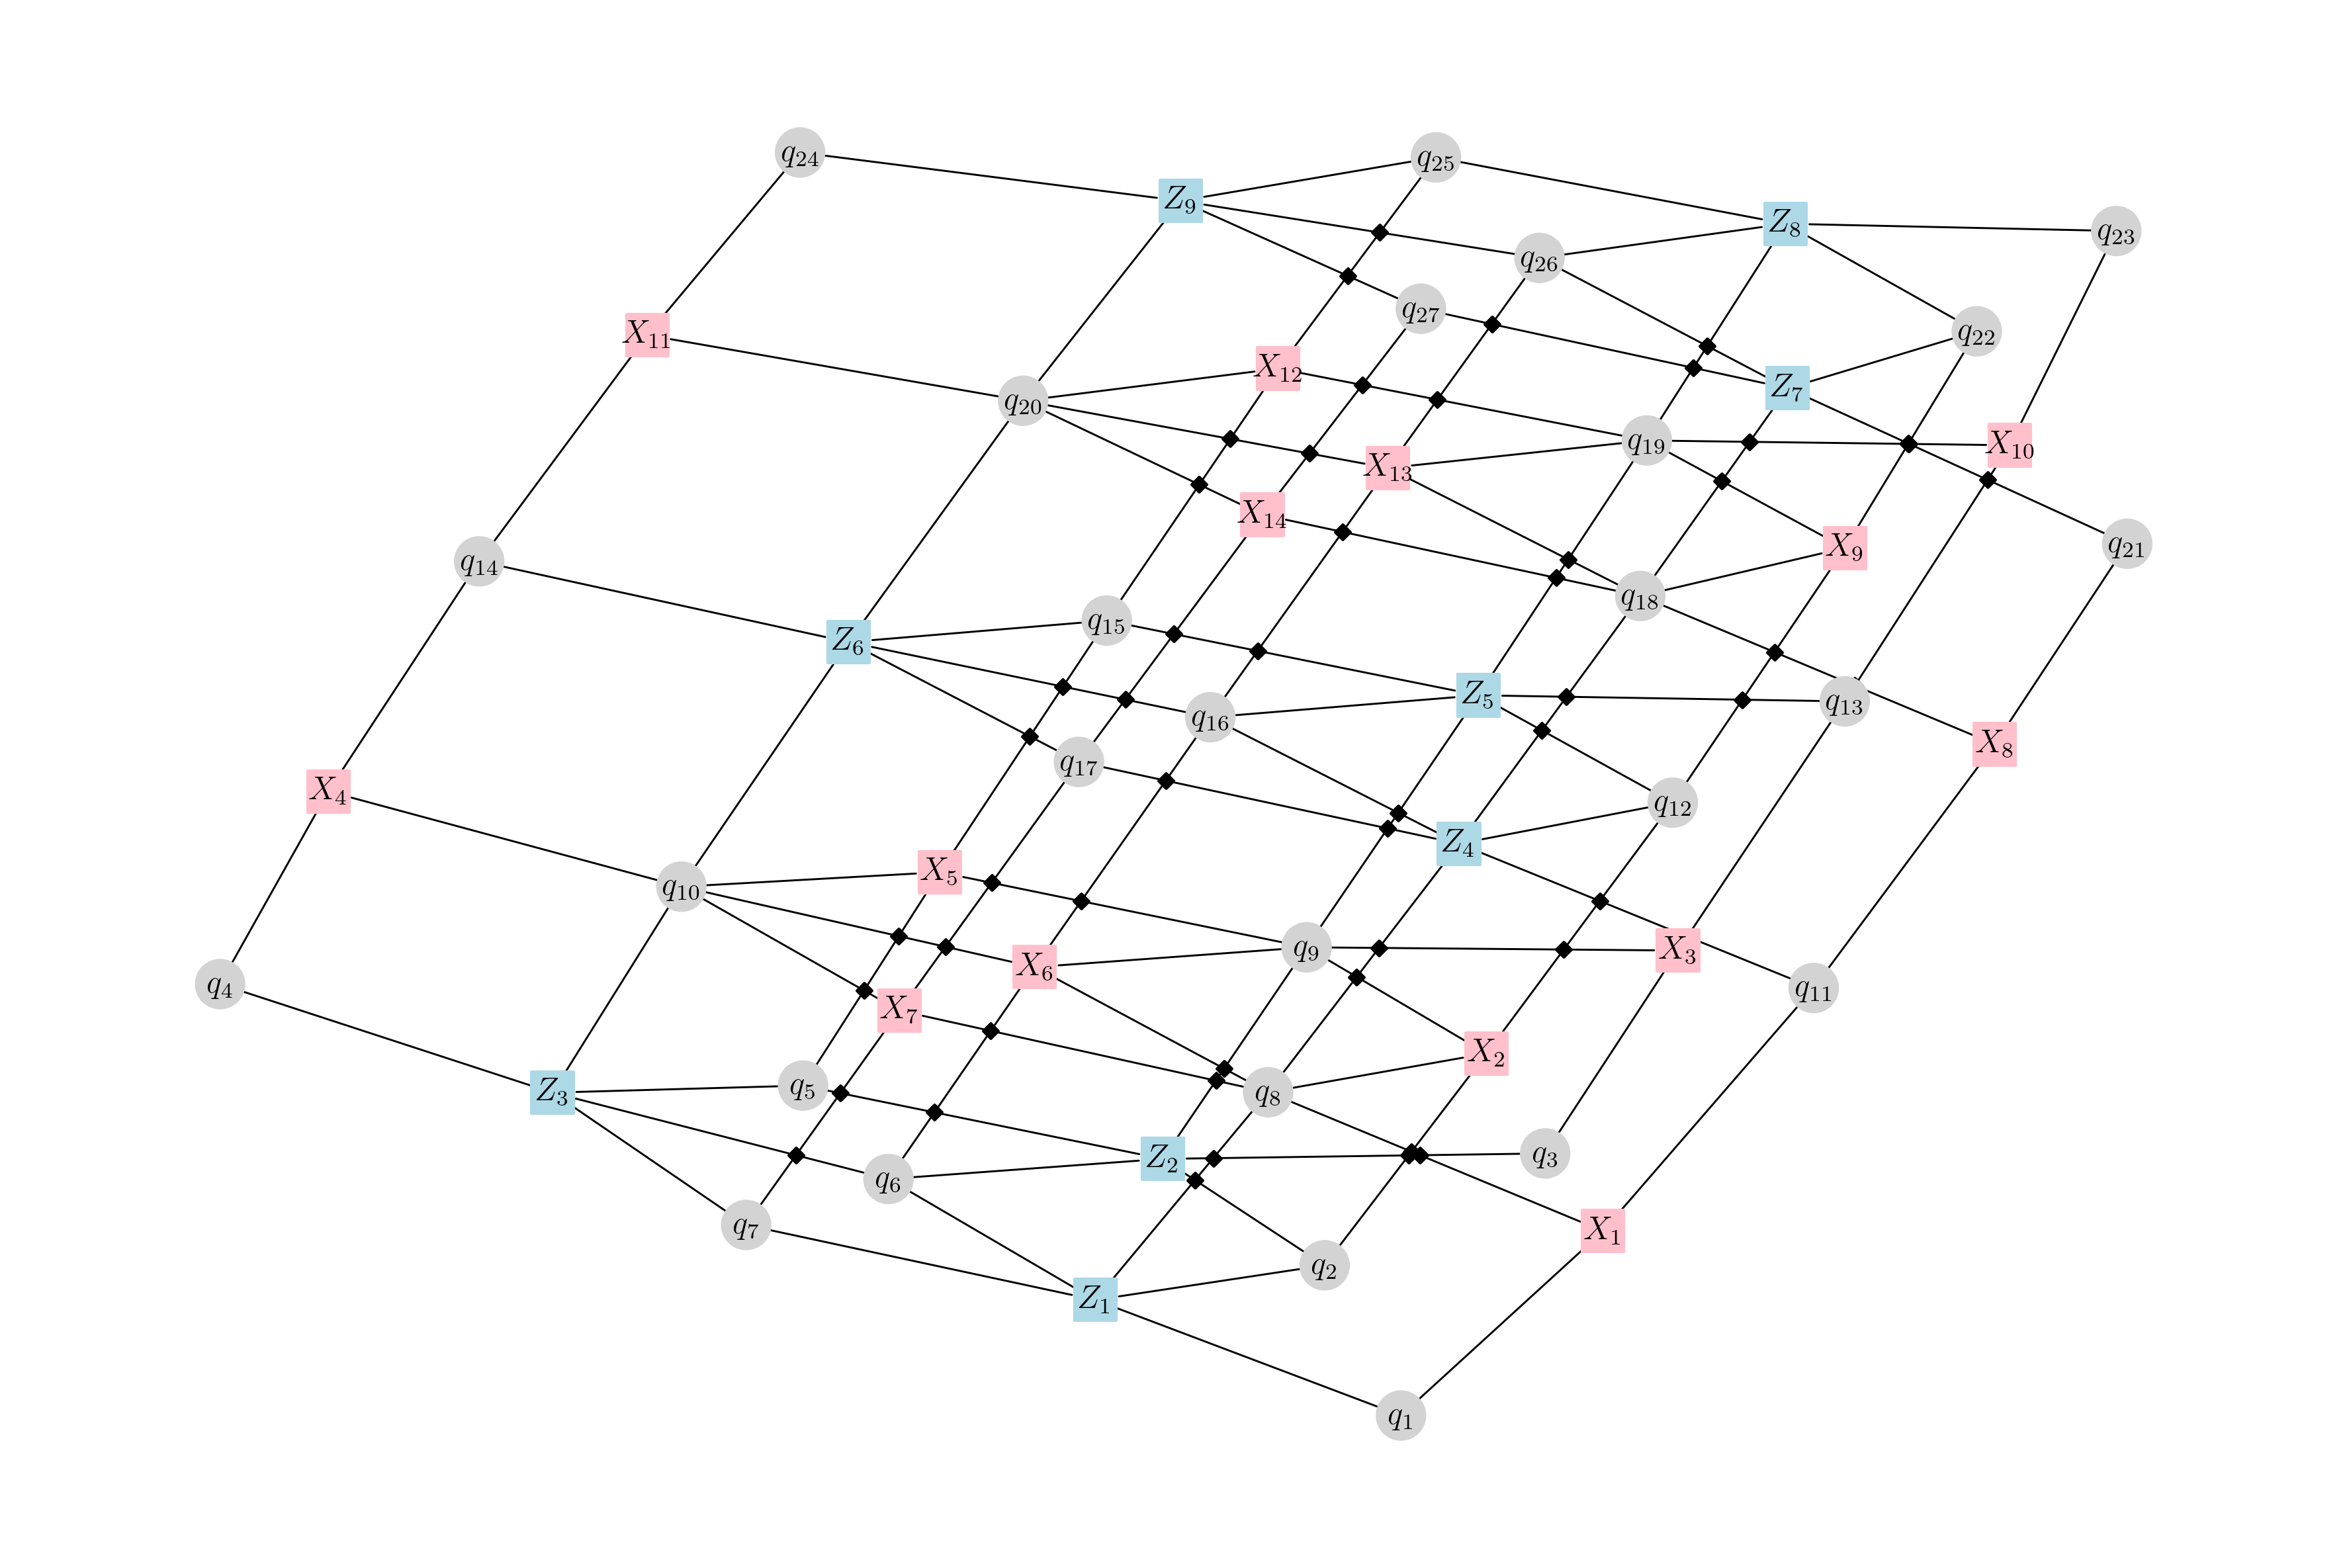

In [15]:
plt.figure(figsize=(15, 10))
hp_code_rep_3_hamming_7_4_spring.draw(with_labels=True)

In [16]:
hp_code_rep_3_hamming_7_4_random = model.StabilizerModel(
    "hypergraph_product_code:x_memory",
    clist1=clist_rep_3,
    clist2=clist_hamming_7_4,
    pos="random",
    rounds=2,
)

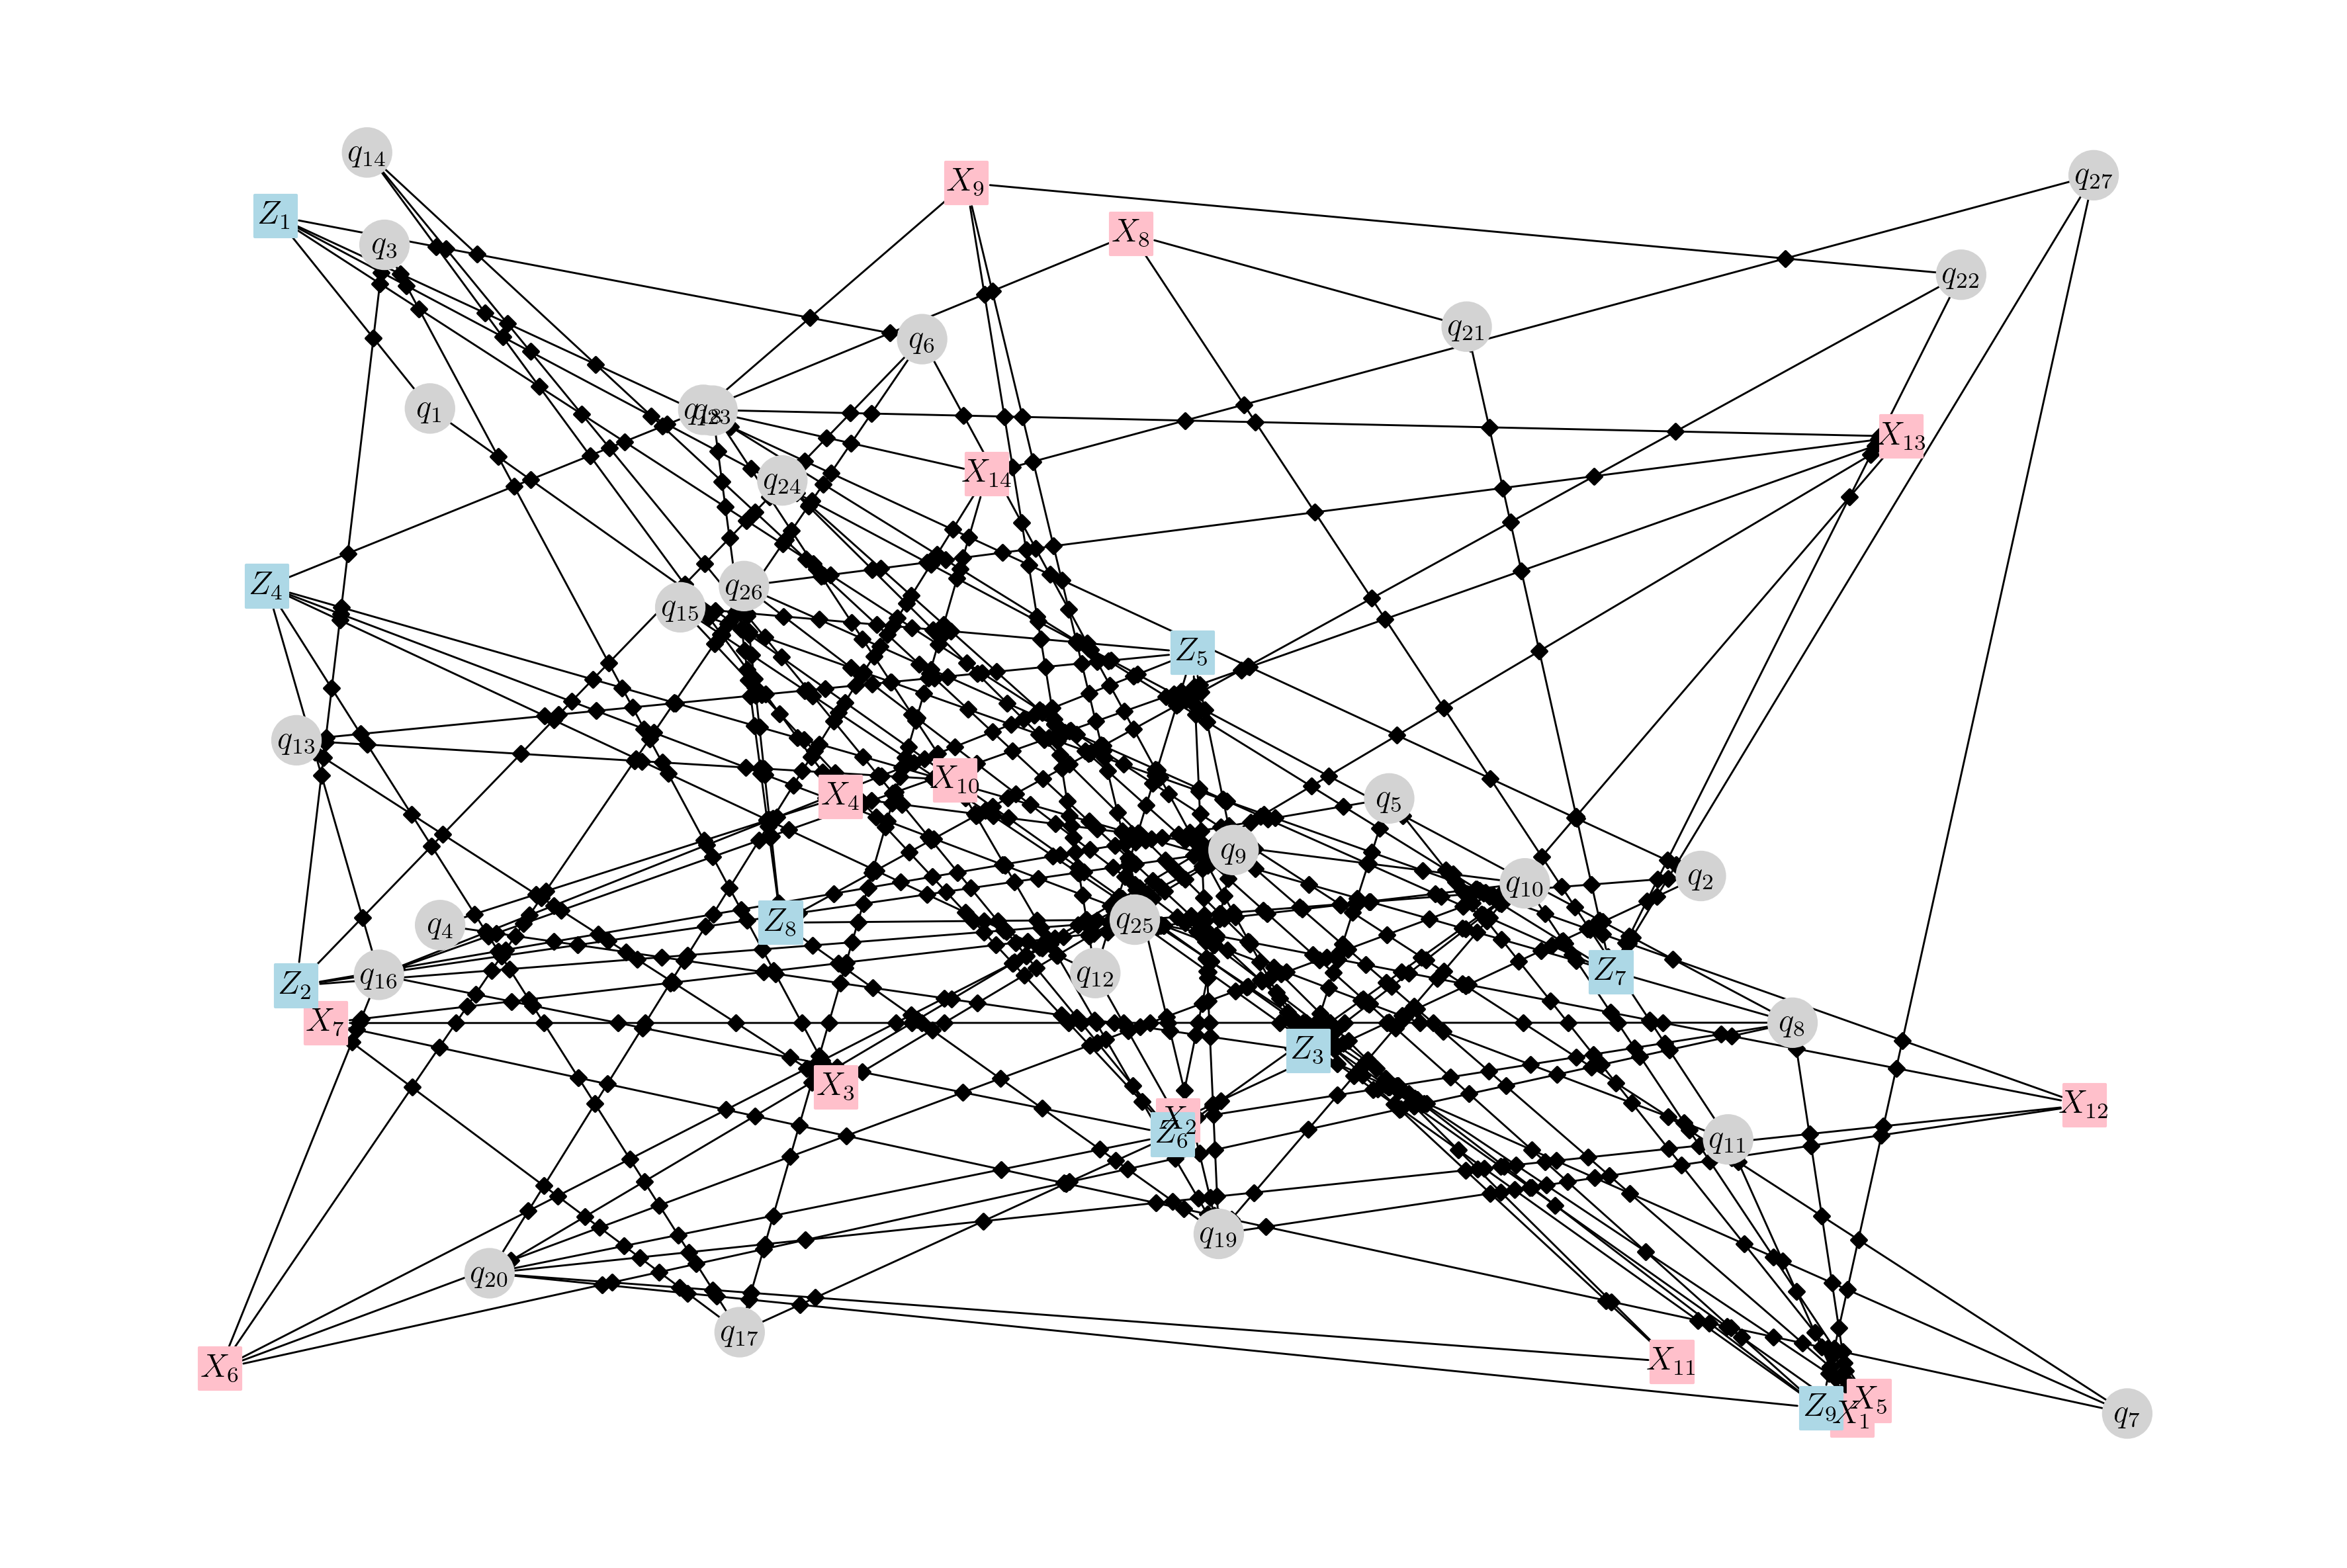

In [17]:
plt.figure(figsize=(15, 10))
hp_code_rep_3_hamming_7_4_random.draw(with_labels=True)

In [18]:
hp_code_rep_3_hamming_7_4_bipartite = model.StabilizerModel(
    "hypergraph_product_code:x_memory",
    clist1=clist_rep_3,
    clist2=clist_hamming_7_4,
    pos="bipartite",
    rounds=2,
)

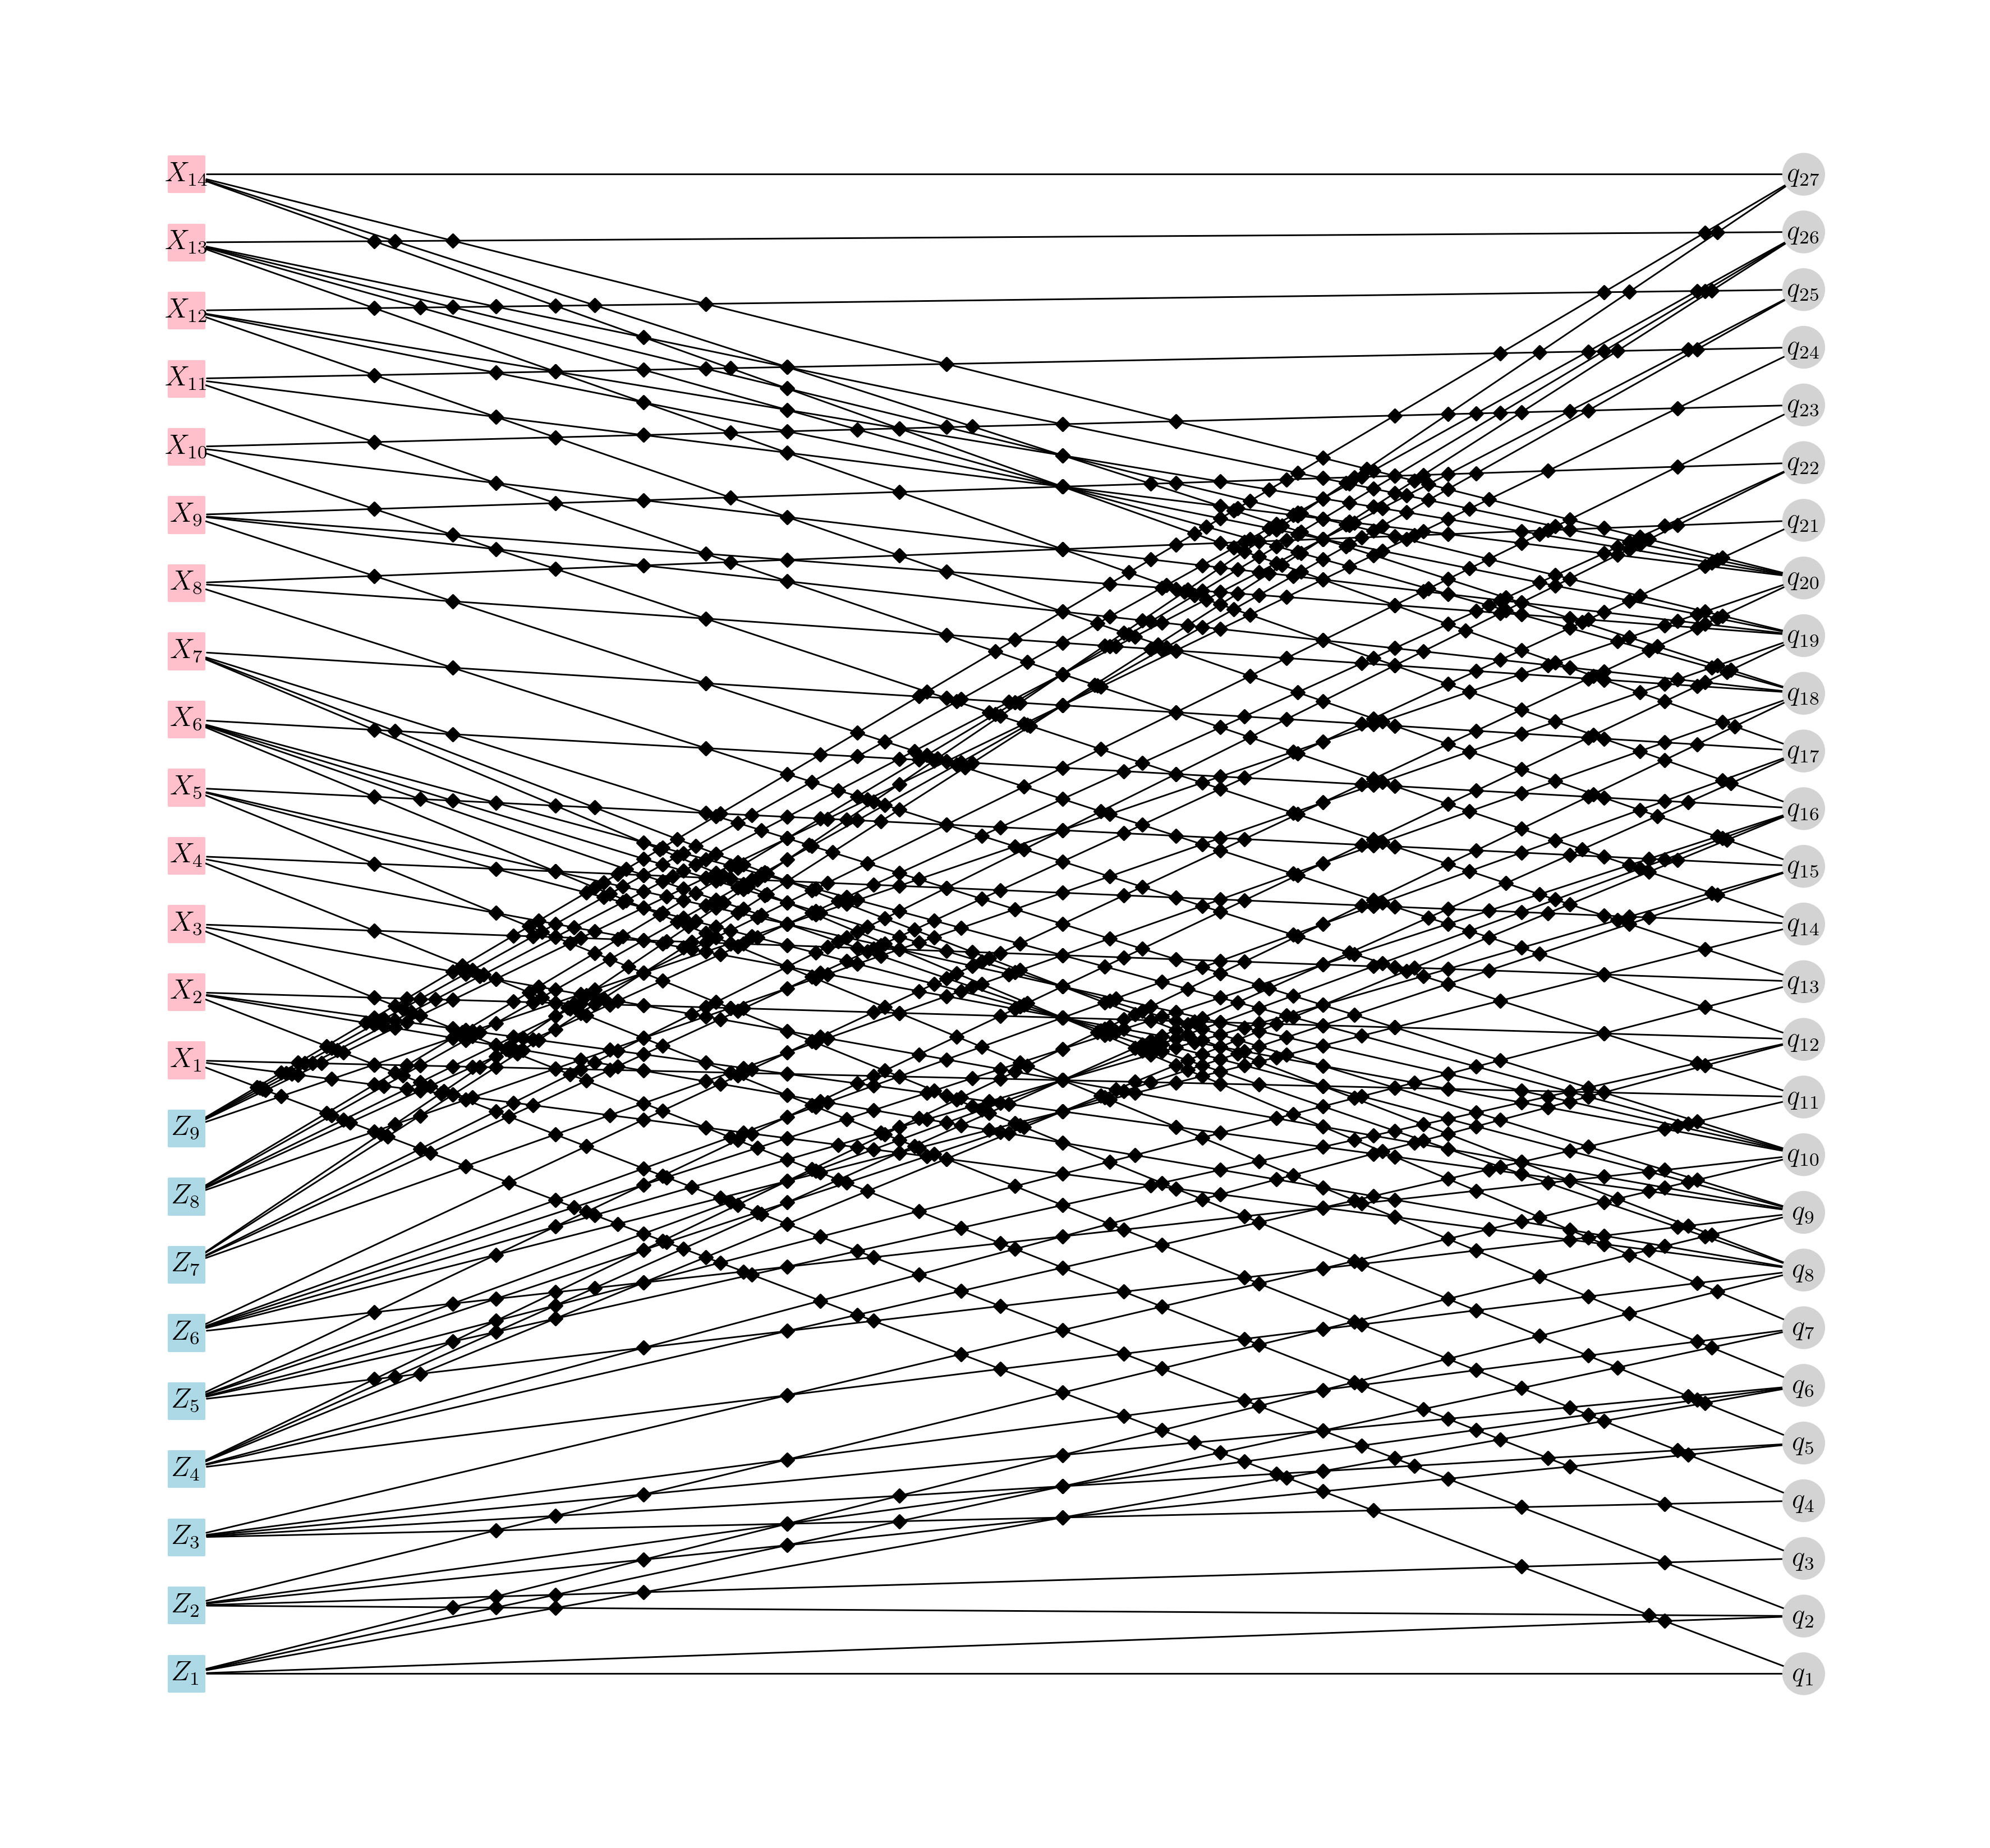

In [19]:
plt.figure(figsize=(15, 14))
hp_code_rep_3_hamming_7_4_bipartite.draw(with_labels=True)

In [20]:
hp_code_rep_3_hamming_7_4_tripartite = model.StabilizerModel(
    "hypergraph_product_code:x_memory",
    clist1=clist_rep_3,
    clist2=clist_hamming_7_4,
    pos="tripartite",
    rounds=2,
)

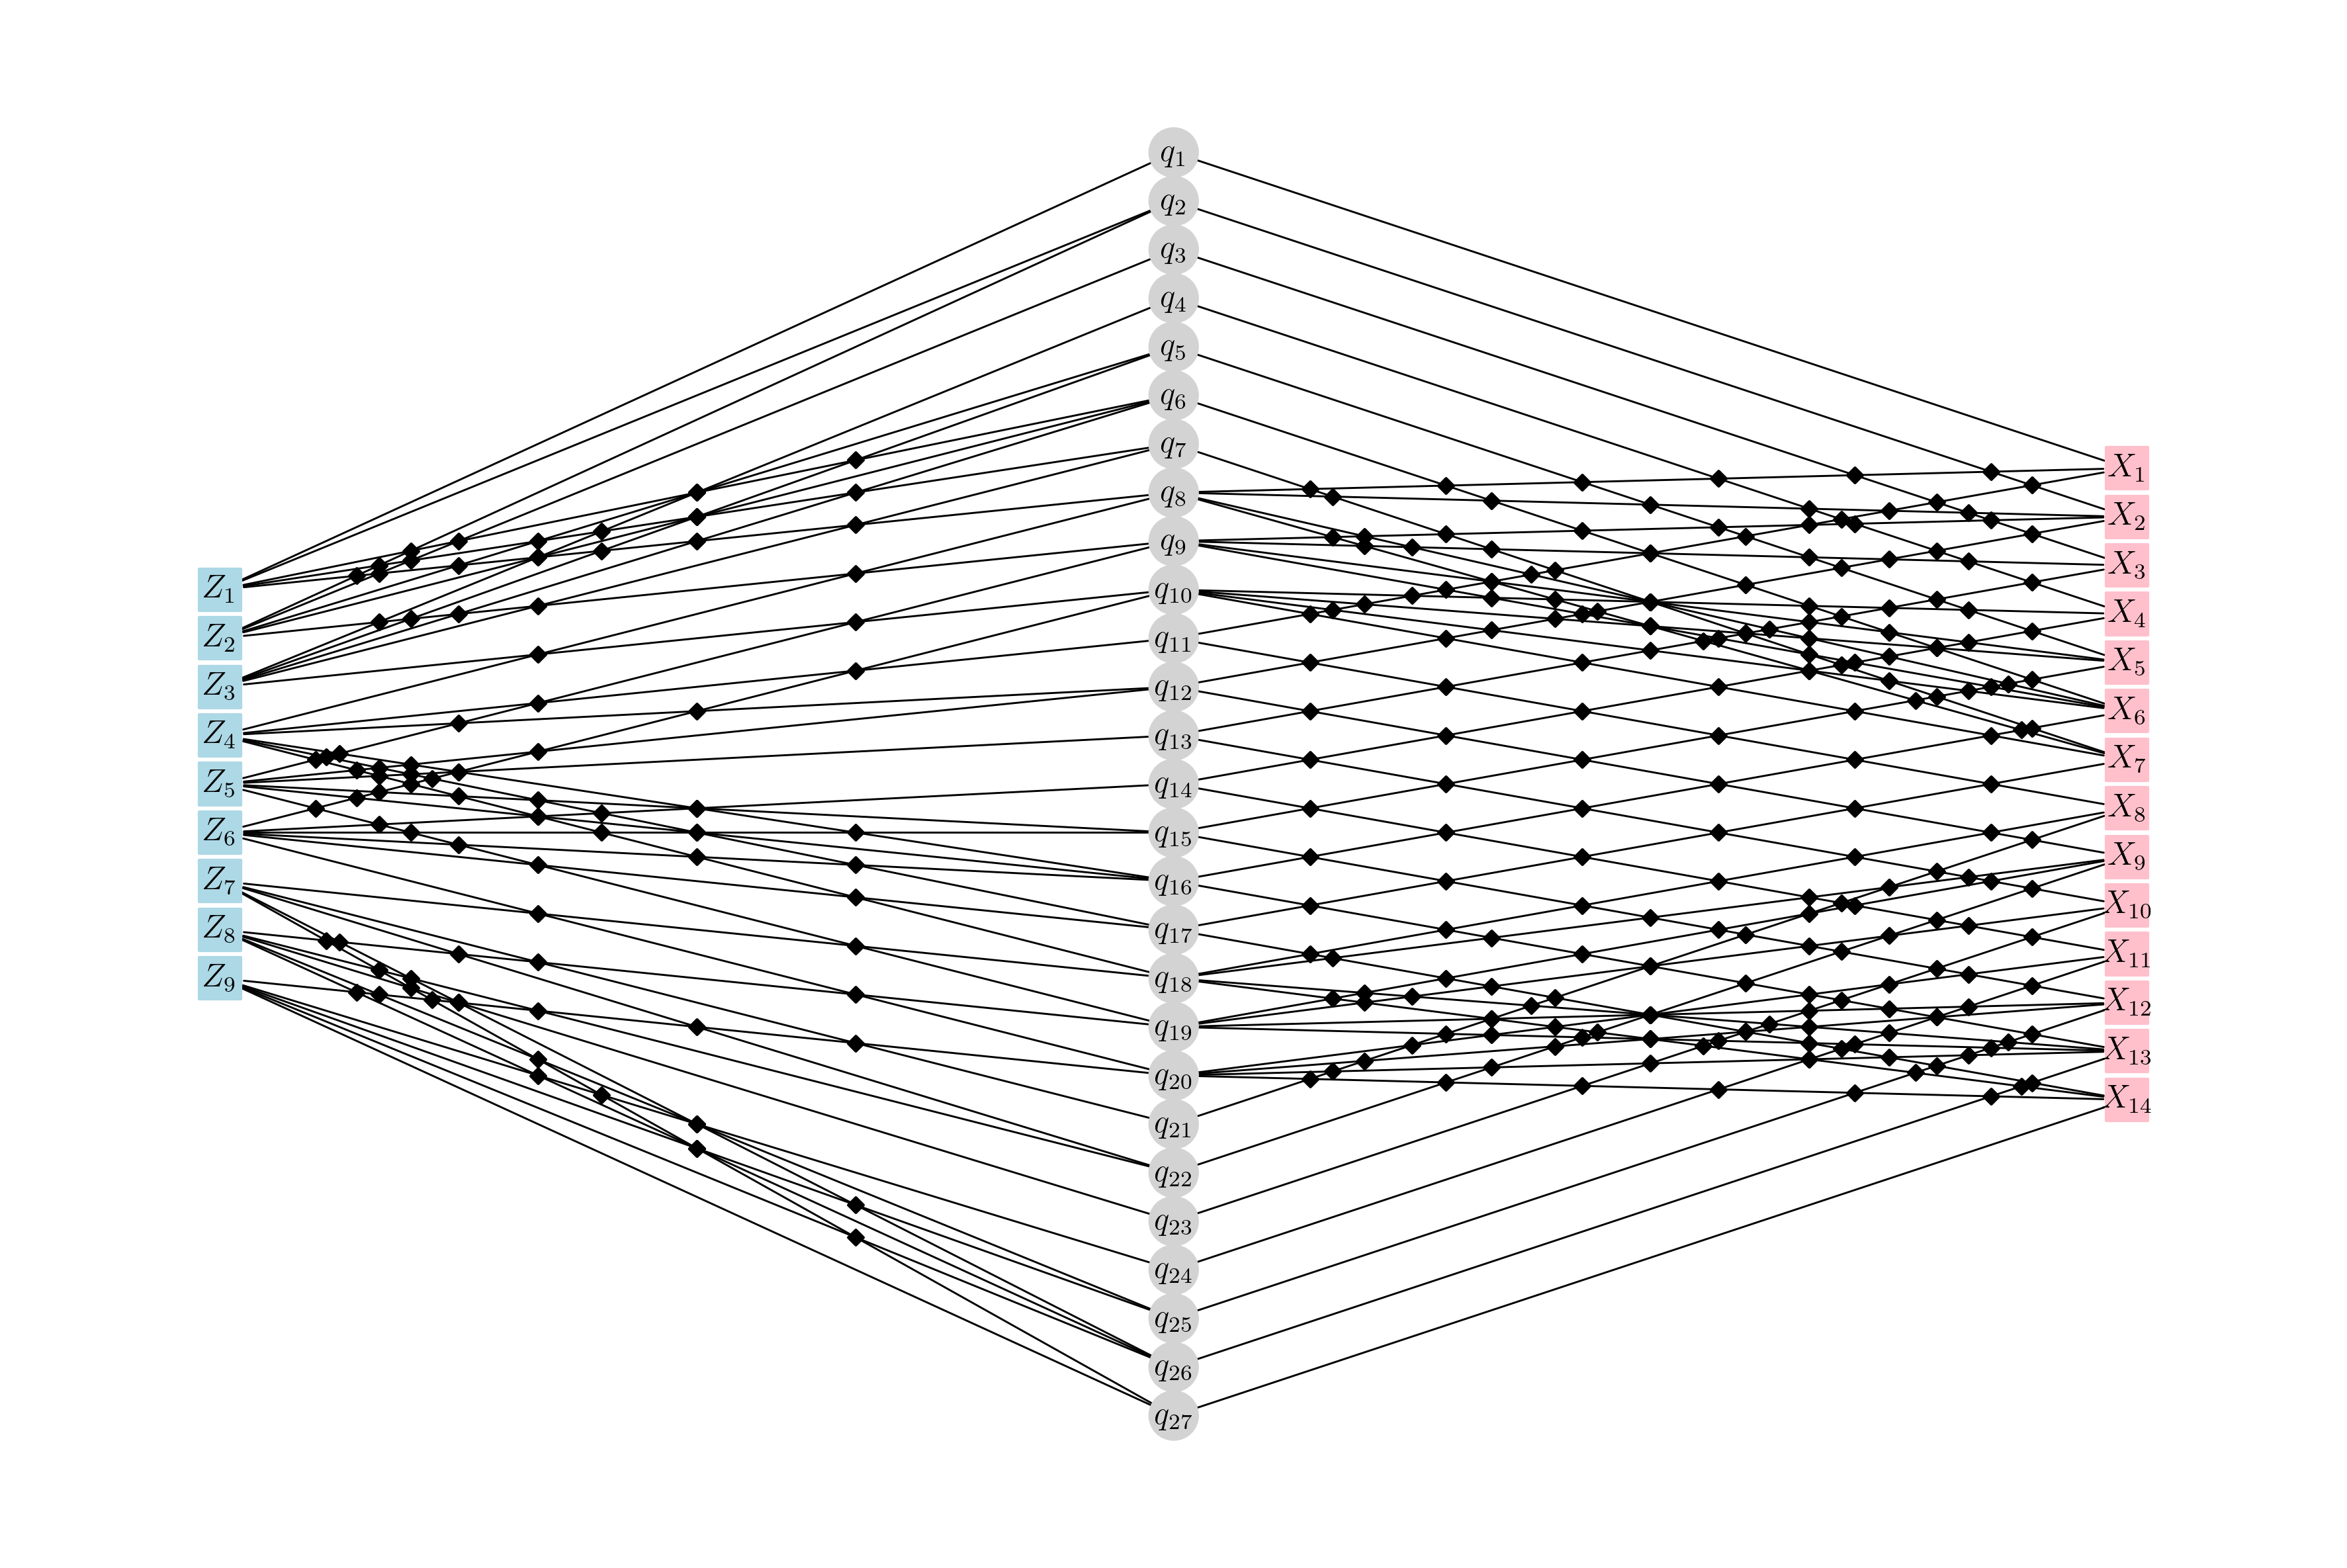

In [21]:
plt.figure(figsize=(15, 10))
hp_code_rep_3_hamming_7_4_tripartite.draw(with_labels=True)

### Simulations

We may test that the crossing noise is correctly implemented. We expect higher crossing noise to increase the logical error rate, especially for lower physical noise.

In [ ]:
from ldpc.sinter_decoders import SinterBpOsdDecoder

In [ ]:
hp_code_tasks = [
    sinter.Task(
        circuit=model.StabilizerModel(
            "hypergraph_product_code:z_memory",
            clist1=clist_rep_3,
            clist2=clist_hamming_7_4,
            pos=pos_rep_3_hamming_7_4_adjusted,
            rounds=3,
            noise_circuit=noise,
            noise_crossing=noise**crossing_noise_exponent,
            noise_data=noise,
            noise_z_check=noise,
            noise_x_check=noise,
        ).circuit,
        json_metadata={
            "noise": noise,
            "crossing_noise": noise**crossing_noise_exponent,
            "crossing_noise_exponent": crossing_noise_exponent,
        },
    )
    for noise in 10 ** np.linspace(-8, -3, 30)
    for crossing_noise_exponent in [1e3, 1, 1e-3]
]

In [ ]:
collected_hp_code_stats = sinter.collect(
    num_workers=4,
    tasks=hp_code_tasks,
    decoders=["bposd"],
    custom_decoders={
        "bposd": SinterBpOsdDecoder(
            max_iter=5,
            bp_method="ms",
            ms_scaling_factor=0.625,
            schedule="parallel",
            osd_method="osd0",
        )
    },
    max_shots=1_000_000,
    max_errors=5_000,
    print_progress=True,
)

In [ ]:
fig = plt.figure(figsize=(8, 5))
sinter.plot_error_rate(
    ax=fig.gca(),
    stats=collected_hp_code_stats,
    x_func=lambda stat: stat.json_metadata["noise"],
    group_func=lambda stat: stat.json_metadata["crossing_noise_exponent"],
)
# plt.ylim(1e-7, 3e-2)
# plt.xlim(4e-5, 1e-3)
plt.loglog()
plt.title("HP Code Error Rates per Round under Circuit Noise")
plt.xlabel("Phyical Error Rate")
plt.ylabel("Logical Error Rate per Round")
plt.grid(which="major")
plt.grid(which="minor")
plt.legend();